<a href="https://colab.research.google.com/github/narae12/aiffel/blob/main/Olist_Delivery_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 통합 배송 데이터 분석

## 데이터 로드 및 초기 설정

In [ ]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import kagglehub
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


## 데이터 로드

In [ ]:
# 데이터 로드_나래
# order_items = pd.read_csv('/content/drive/MyDrive/아이펠/data/olist_order_items_dataset.csv')
# products = pd.read_csv('/content/drive/MyDrive/아이펠/data/olist_products_dataset.csv')
# orders = pd.read_csv('/content/drive/MyDrive/아이펠/data/olist_orders_dataset.csv')
# customers = pd.read_csv("/content/drive/MyDrive/아이펠/data/olist_customers_dataset.csv")
# sellers = pd.read_csv("/content/drive/MyDrive/아이펠/data/olist_sellers_dataset.csv")

In [ ]:
# 데이터 로드_소희

# Download latest version
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

# CSV 파일로 읽기
# 제품 관련 데이터
orders = pd.read_csv(os.path.join(path, 'olist_orders_dataset.csv'))
order_items = pd.read_csv(os.path.join(path, 'olist_order_items_dataset.csv'))
products = pd.read_csv(os.path.join(path, 'olist_products_dataset.csv'))
sellers = pd.read_csv(os.path.join(path, 'olist_sellers_dataset.csv'))
customers = pd.read_csv(os.path.join(path, 'olist_customers_dataset.csv'))

100%|██████████| 42.6M/42.6M [00:01<00:00, 27.2MB/s]

Extracting files...


## 데이터 병합 및 전처리

### 데이터 병합

In [ ]:
# 병합 단계
merge_df = order_items.merge(products, on='product_id', how='left')
full_df = merge_df.merge(orders, on='order_id', how='left')
full_df = full_df.merge(customers[['customer_id', 'customer_city']], on='customer_id', how='left')
full_df = full_df.merge(sellers[['seller_id', 'seller_city']], on='seller_id', how='left')

### 날짜 데이터 변환 및 추가 전처리

In [ ]:
# 날짜 데이터 변환
full_df['order_delivered_customer_date'] = pd.to_datetime(full_df['order_delivered_customer_date'])
full_df['order_delivered_carrier_date'] = pd.to_datetime(full_df['order_delivered_carrier_date'])
full_df['order_estimated_delivery_date'] = pd.to_datetime(full_df['order_estimated_delivery_date'])

# 배송 시간 계산
full_df['actual_shipping_time'] = (full_df['order_delivered_customer_date'] - full_df['order_delivered_carrier_date']).dt.days
# 배송 지연 여부 (예측 배송 날짜보다 늦게 도착하면 지연)
full_df['delivery_delay'] = (full_df['order_delivered_customer_date'] - full_df['order_estimated_delivery_date']).dt.days # 지연 여부 (True / False)
# full_df 생성 (merge_df와 orders 데이터 병합)
full_df['delayed'] = full_df['delivery_delay'] > 0

In [ ]:
full_df.shape

(112650, 27)

In [ ]:
full_df.isnull().sum() #매우 중요한 변수들이므로 결측치는 drop

,0
order_id,0
order_item_id,0
product_id,0
seller_id,0
shipping_limit_date,0
price,0
freight_value,0
product_category_name,1603
product_name_lenght,1603
product_description_lenght,1603


### 결측값 처리

In [ ]:
# 결측값 제거
full_df = full_df.dropna(subset=['actual_shipping_time', 'delivery_delay'])

In [ ]:
full_df.shape #약 2퍼센트 제거로 문제 없을것이라 판단

(110195, 27)

### 데이터 탐색

In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110195 entries, 0 to 112649
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110195 non-null  object        
 1   order_item_id                  110195 non-null  int64         
 2   product_id                     110195 non-null  object        
 3   seller_id                      110195 non-null  object        
 4   shipping_limit_date            110195 non-null  object        
 5   price                          110195 non-null  float64       
 6   freight_value                  110195 non-null  float64       
 7   product_category_name          108658 non-null  object        
 8   product_name_lenght            108658 non-null  float64       
 9   product_description_lenght     108658 non-null  float64       
 10  product_photos_qty             108658 non-null  float64       
 11  produ

## EDA (탐색적 데이터 분석)

### 무게와 배송 시간 비교 (무거운 제품 vs 가벼운 제품 배송 차이 확인하기)

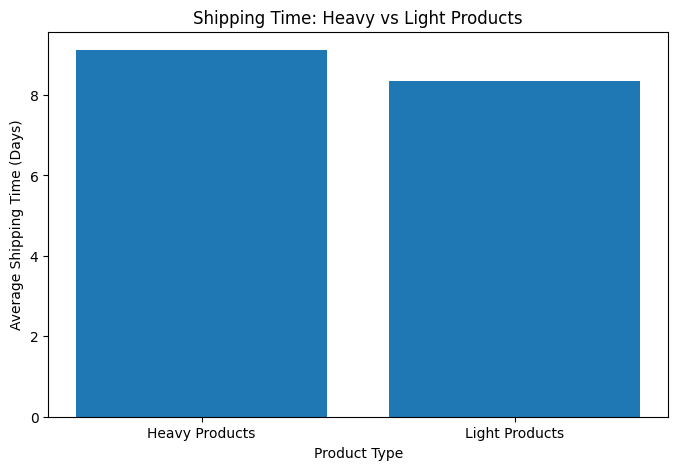

In [ ]:
# 제품 무게 기준 그룹 나누기(무거운 제품: 상위 50%, 가벼운 제품: 하위 50%)
median_weight = full_df["product_weight_g"].median()
heavy_products = full_df[full_df["product_weight_g"] >= median_weight]
light_products = full_df[full_df["product_weight_g"] < median_weight]

# 각 그룹별 평균 배송 시간 계산
avg_shipping_time_heavy = heavy_products["actual_shipping_time"].mean()
avg_shipping_time_light = light_products["actual_shipping_time"].mean()

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(["Heavy Products", "Light Products"], [avg_shipping_time_heavy, avg_shipping_time_light])
plt.xlabel("Product Type")
plt.ylabel("Average Shipping Time (Days)")
plt.title("Shipping Time: Heavy vs Light Products")
plt.show()

### 부피와 배송 시간 비교 (크기가 큰 제품 작은 제품 평균 배송 시간 비교하기)

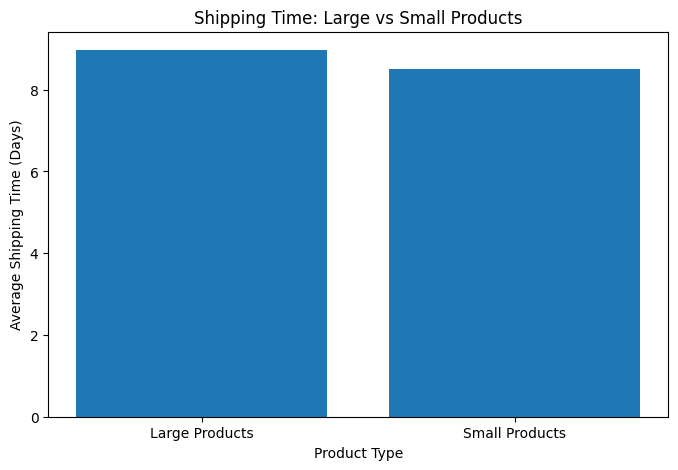

In [ ]:
# 제품 부피 계산
full_df["product_volume_cm3"] = (
    full_df["product_length_cm"] * full_df["product_width_cm"] * full_df["product_height_cm"]
)

# 부피 기준 그룹 나누기
median_volume = full_df["product_volume_cm3"].median()
large_products = full_df[full_df["product_volume_cm3"] >= median_volume]
small_products = full_df[full_df["product_volume_cm3"] < median_volume]

# 평균 배송 시간 계산
avg_shipping_time_large = large_products["actual_shipping_time"].mean()
avg_shipping_time_small = small_products["actual_shipping_time"].mean()

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(["Large Products", "Small Products"], [avg_shipping_time_large, avg_shipping_time_small])
plt.xlabel("Product Type")
plt.ylabel("Average Shipping Time (Days)")
plt.title("Shipping Time: Large vs Small Products")
plt.show()

### 배송 지연 분석 (가장 배송이 늦어지는 제품 찾아보기)

In [ ]:
# 지연된 주문 필터링
delayed_orders = full_df[full_df["delayed"]]

# 제품별 지연 횟수 집계
delayed_products_count = delayed_orders.groupby("product_id").size().reset_index(name="delay_count")

# 지연 횟수 상위 10개 제품
top_delayed_products = delayed_products_count.sort_values(by="delay_count", ascending=False).head(10)

# 제품 카테고리 추가
top_delayed_products = pd.merge(top_delayed_products, products[["product_id", "product_category_name"]], on="product_id", how="left")

# 결과 표시
print(top_delayed_products)

                         product_id  delay_count   product_category_name
0  422879e10f46682990de24d770e7f83d           47      ferramentas_jardim
1  aca2eb7d00ea1a7b8ebd4e68314663af           42        moveis_decoracao
2  3fbc0ef745950c7932d5f2a446189725           39            beleza_saude
3  389d119b48cf3043d311335e499d9c6b           30      ferramentas_jardim
4  368c6c730842d78016ad823897a372db           29      ferramentas_jardim
5  99a4788cb24856965c36a24e339b6058           29         cama_mesa_banho
6  53759a2ecddad2bb87a079a1f1519f73           29      ferramentas_jardim
7  bb50f2e236e5eea0100680137654686c           28            beleza_saude
8  19c91ef95d509ea33eda93495c4d3481           28            beleza_saude
9  e53e557d5a159f5aa2c5e995dfdf244b           25  informatica_acessorios


### 왜 늦어졌는지 분석해 보기

In [ ]:
top_delayed_products

,product_id,delay_count,product_category_name
0,422879e10f46682990de24d770e7f83d,47,ferramentas_jardim
1,aca2eb7d00ea1a7b8ebd4e68314663af,42,moveis_decoracao
2,3fbc0ef745950c7932d5f2a446189725,39,beleza_saude
3,389d119b48cf3043d311335e499d9c6b,30,ferramentas_jardim
4,368c6c730842d78016ad823897a372db,29,ferramentas_jardim
5,99a4788cb24856965c36a24e339b6058,29,cama_mesa_banho
6,53759a2ecddad2bb87a079a1f1519f73,29,ferramentas_jardim
7,bb50f2e236e5eea0100680137654686c,28,beleza_saude
8,19c91ef95d509ea33eda93495c4d3481,28,beleza_saude
9,e53e557d5a159f5aa2c5e995dfdf244b,25,informatica_acessorios


In [ ]:
top_delayed_weights = products["product_weight_g"].mean()
top_delayed_volumes = ( products["product_length_cm"] *
                        products["product_width_cm"] *
                        products["product_height_cm"]).mean()

# 2️⃣ 일반 제품(지연되지 않은 제품)들의 무게 & 부피 평균 계산
normal_products = full_df[~full_df["product_id"].isin(top_delayed_products["product_id"])]
normal_weights = normal_products["product_weight_g"].mean()
normal_volumes = (normal_products["product_length_cm"] *
                  normal_products["product_width_cm"] *
                  normal_products["product_height_cm"]).mean()

Text(0.5, 1.0, 'Comparison of Average Volume')

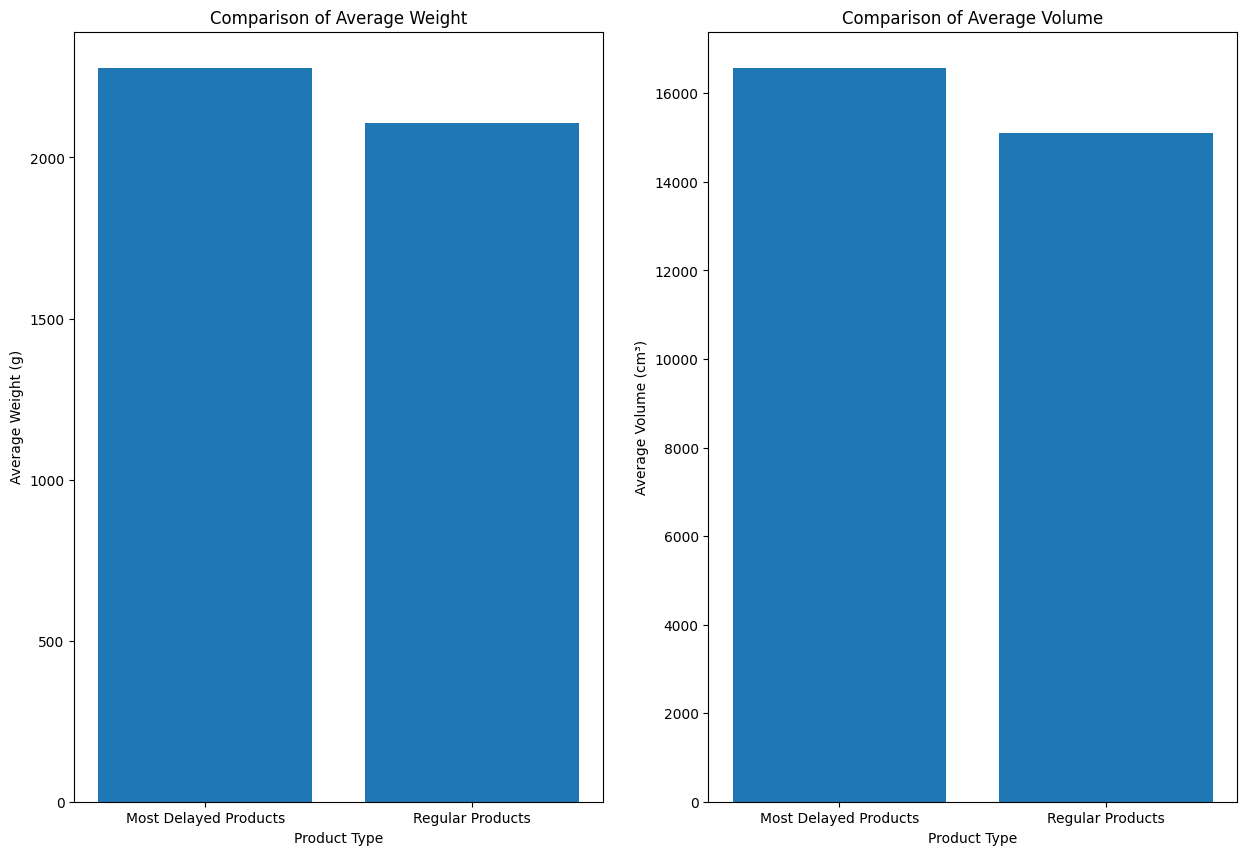

In [ ]:
# 📊 시각화
plt.figure(figsize=(15, 10))

# 무게 비교
plt.subplot(1, 2, 1)
plt.bar(["Most Delayed Products", "Regular Products"], [top_delayed_weights, normal_weights])
plt.xlabel("Product Type")
plt.ylabel("Average Weight (g)")
plt.title("Comparison of Average Weight")


# 부피 비교
plt.subplot(1, 2, 2)
plt.bar(["Most Delayed Products", "Regular Products"], [top_delayed_volumes, normal_volumes])
plt.xlabel("Product Type")
plt.ylabel("Average Volume (cm³)")
plt.title("Comparison of Average Volume")

### 거리에 따른 배송지연 분석해보기

In [ ]:
#우편 번호로 분석 해보려 했는데 우편번호 비슷한걸로 분석하기에는 너무 근거 없어서
#✅ 새로운 분석 방법 (도시 기반)
# Step 1: 고객과 판매자의 도시 정보 추가
# Step 2: 같은 도시에 있는 경우와 다른 도시에 있는 경우 나누기
# Step 3: 각 그룹별 평균 배송 지연 시간 비교

In [ ]:
# 🚀 같은 도시에 있는 경우와 다른 도시에 있는 경우 구분
full_df['same_city'] = full_df['customer_city'] == full_df['seller_city']
# 각 그룹별 평균 배송 지연 시간 계산
city_delay = full_df.groupby('same_city')['delivery_delay'].mean().reset_index()
city_delay['same_city'] = city_delay['same_city'].map({True: 'Same City', False: 'Different City'})
city_delay

# 예상 배송일보다 더 빨리 도착하는 경향이 있지만 다른 값이더 오래 걸림

,same_city,delivery_delay
0,Different City,-12.172794
1,Same City,-9.430818


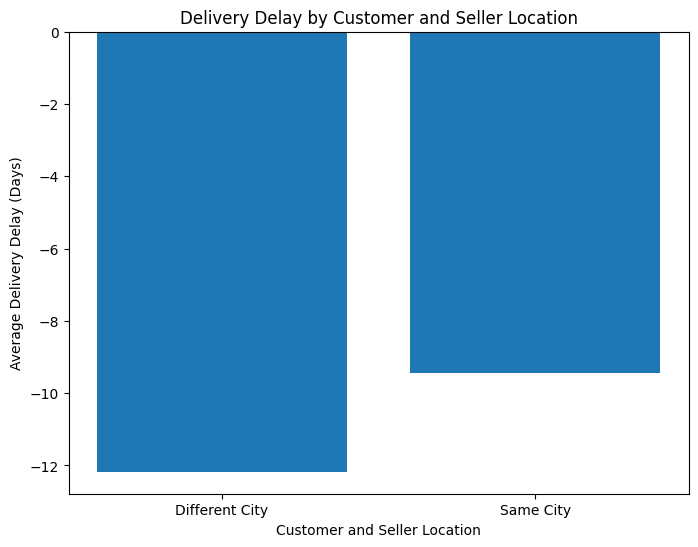

In [ ]:
# 📊 시각화
plt.figure(figsize=(8, 6))
plt.bar(city_delay['same_city'], city_delay['delivery_delay'])
plt.xlabel("Customer and Seller Location")
plt.ylabel("Average Delivery Delay (Days)")
plt.title("Delivery Delay by Customer and Seller Location")
plt.show()


#도시별 배송기간 확인하기

In [ ]:
# 도시별 평균 배송 지연 시간 계산
city_delay = full_df.groupby('customer_city')['delivery_delay'].mean().reset_index()


In [ ]:
# 주문이 많은 상위 10개 도시만 추출 (주문 수가 많은 순서대로 정렬)
top_cities = full_df['customer_city'].value_counts().head(10).index
city_delay = city_delay[city_delay['customer_city'].isin(top_cities)]

In [ ]:
# 도시별 평균 배송 지연 시간을 내림차순 정렬
city_delay_sorted_desc = city_delay.sort_values(by="delivery_delay", ascending=False)

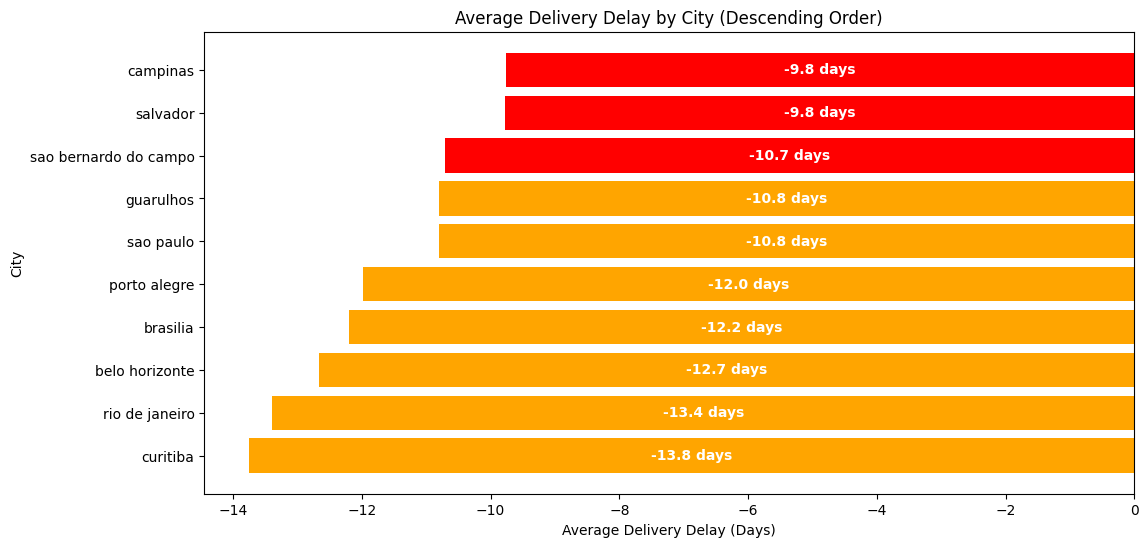

In [ ]:
# 시각화 진행 (내림차순 정렬, 상위 3개 도시 강조)
plt.figure(figsize=(12, 6))

# 막대 색상 설정 (상위 3개 도시만 빨간색)
colors = ['red' if i < 3 else 'orange' for i in range(len(city_delay_sorted_desc))]

bars = plt.barh(city_delay_sorted_desc['customer_city'], city_delay_sorted_desc['delivery_delay'], color=colors)

# 각 막대 안에 평균 지연 일수 표시 (막대 내부에 글씨 넣기)
for bar, delay in zip(bars, city_delay_sorted_desc['delivery_delay']):
    plt.text(bar.get_width() / 2,  # x 위치 (막대의 중간)
             bar.get_y() + bar.get_height() / 2,  # y 위치 (막대의 중앙)
             f"{delay:.1f} days",  # 표시할 텍스트 (소수점 1자리까지)
             va='center', ha='center', fontsize=10, color='white', fontweight='bold')

plt.xlabel("Average Delivery Delay (Days)")
plt.ylabel("City")
plt.title("Average Delivery Delay by City (Descending Order)")
plt.gca().invert_yaxis()



## 모델링 및 평가

### 데이터 준비

In [ ]:
full_df.shape

(110195, 29)

In [ ]:
# 특성 선택
feature_columns = [
    'product_weight_g', 'product_length_cm', 'product_height_cm',
    'product_width_cm', 'product_volume_cm3', 'freight_value'
]

# 데이터 분할 및 스케일링
X = full_df[feature_columns]
y = full_df['delayed'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

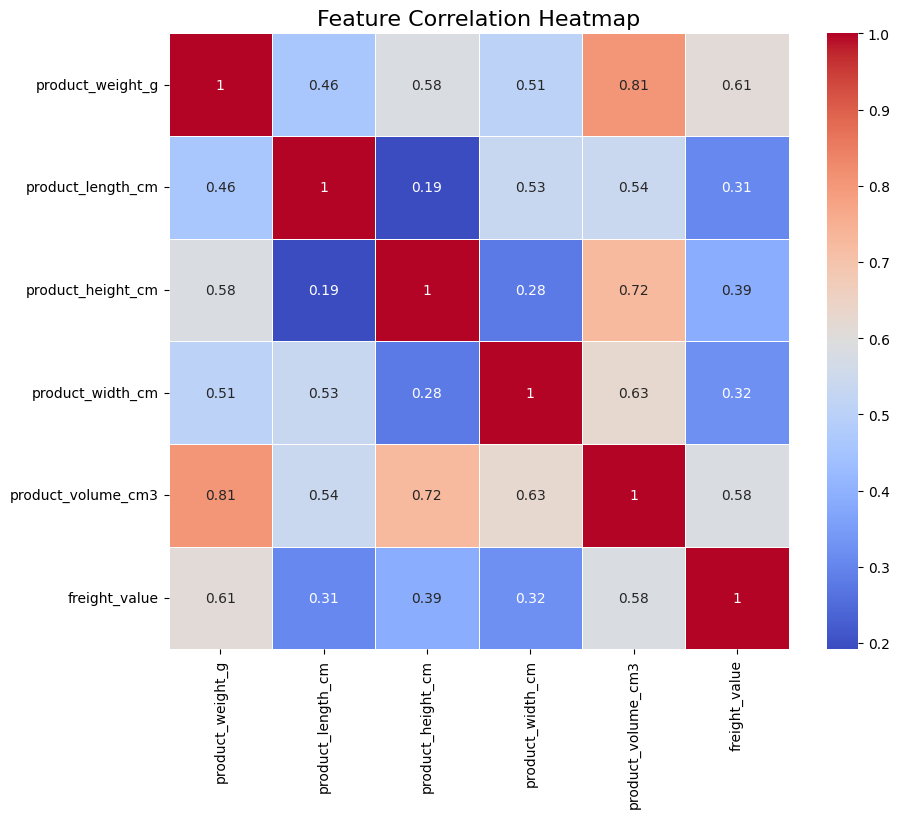

In [ ]:
corr_matrix = full_df[[
    'product_weight_g', 'product_length_cm', 'product_height_cm',
    'product_width_cm', 'product_volume_cm3', 'freight_value'
]].corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show()

###  모델 학습 및 평가

In [ ]:
# Step 1: 결측값 처리 (평균값으로 대체)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_scaled)  # 학습 데이터 결측값 처리
X_test_imputed = imputer.transform(X_test_scaled)       # 테스트 데이터 결측값 처리

# Step 2: 클래스 불균형 처리 (SMOTE 적용)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)

# Step 3: 스케일링
scaler = StandardScaler()
X_train_scaled_final = scaler.fit_transform(X_train_resampled)
X_test_scaled_final = scaler.transform(X_test_imputed)

# Step 4: 모델 정의
models = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(random_state=42, scale_pos_weight=len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1]))
}

# Step 5: 모델 학습 및 평가
results = {}

for name, model in models.items():
    # 모델 학습
    model.fit(X_train_scaled_final, y_train_resampled)

    # 예측 결과
    y_pred = model.predict(X_test_scaled_final)
    y_pred_proba = model.predict_proba(X_test_scaled_final)[:, 1]  # ROC-AUC 계산용 확률값

    # 평가 지표 계산
    classification = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    confusion = confusion_matrix(y_test, y_pred)

    # 결과 저장
    results[name] = {
        'classification_report': classification,
        'roc_auc': roc_auc,
        'confusion_matrix': confusion
    }

    # 결과 출력
    print(f"\n{name} Results:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{confusion}")



Random Forest Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     20535
           1       0.20      0.23      0.21      1504

    accuracy                           0.89     22039
   macro avg       0.57      0.58      0.58     22039
weighted avg       0.89      0.89      0.89     22039

ROC-AUC: 0.6515
Confusion Matrix:
[[19209  1326]
 [ 1165   339]]

Logistic Regression Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82     20535
           1       0.09      0.37      0.15      1504

    accuracy                           0.70     22039
   macro avg       0.52      0.55      0.48     22039
weighted avg       0.88      0.70      0.78     22039

ROC-AUC: 0.5845
Confusion Matrix:
[[14960  5575]
 [  943   561]]

XGBoost Results:
Classification Report:
              precision    recall  f1-score   support

           0       0

In [ ]:
# # PCA 버전

# from sklearn.decomposition import PCA
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
# from imblearn.over_sampling import SMOTE
# from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# # Step 1: 결측값 처리 (평균값으로 대체)
# imputer = SimpleImputer(strategy='mean')
# X_train_imputed = imputer.fit_transform(X_train_scaled)  # 학습 데이터 결측값 처리
# X_test_imputed = imputer.transform(X_test_scaled)       # 테스트 데이터 결측값 처리

# # Step 2: PCA 적용 (설명 분산 비율을 기준으로 차원 축소, 예: 95% 이상 유지)
# pca = PCA(n_components=0.95, random_state=42)
# X_train_pca = pca.fit_transform(X_train_imputed)
# X_test_pca = pca.transform(X_test_imputed)

# # Step 3: 클래스 불균형 처리 (SMOTE 적용)
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

# # Step 4: 스케일링
# scaler = StandardScaler()
# X_train_scaled_final = scaler.fit_transform(X_train_resampled)
# X_test_scaled_final = scaler.transform(X_test_pca)

# # Step 5: 모델 정의
# models = {
#     'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
#     'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
#     'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1]))
# }

# # Step 6: 모델 학습 및 평가
# results = {}

# for name, model in models.items():
#     # 모델 학습
#     model.fit(X_train_scaled_final, y_train_resampled)

#     # 예측 결과
#     y_pred = model.predict(X_test_scaled_final)
#     y_pred_proba = model.predict_proba(X_test_scaled_final)[:, 1]  # ROC-AUC 계산용 확률값

#     # 평가 지표 계산
#     classification = classification_report(y_test, y_pred, output_dict=True)
#     roc_auc = roc_auc_score(y_test, y_pred_proba)
#     confusion = confusion_matrix(y_test, y_pred)

#     # 결과 저장
#     results[name] = {
#         'classification_report': classification,
#         'roc_auc': roc_auc,
#         'confusion_matrix': confusion
#     }

#     # 결과 출력
#     print(f"\n{name} Results:")
#     print("Classification Report:")
#     print(classification_report(y_test, y_pred))
#     print(f"ROC-AUC: {roc_auc:.4f}")
#     print(f"Confusion Matrix:\n{confusion}")


Random Forest Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     20535
           1       0.18      0.27      0.21      1504

    accuracy                           0.86     22039
   macro avg       0.56      0.59      0.57     22039
weighted avg       0.89      0.86      0.88     22039

ROC-AUC: 0.6567
Confusion Matrix:
[[18615  1920]
 [ 1096   408]]

Logistic Regression Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.72      0.82     20535
           1       0.09      0.37      0.14      1504

    accuracy                           0.70     22039
   macro avg       0.51      0.55      0.48     22039
weighted avg       0.88      0.70      0.77     22039

ROC-AUC: 0.5841
Confusion Matrix:
[[14877  5658]
 [  948   556]]

XGBoost Results:
Classification Report:
              precision    recall  f1-score   support

           0       0

### 결과 시각화

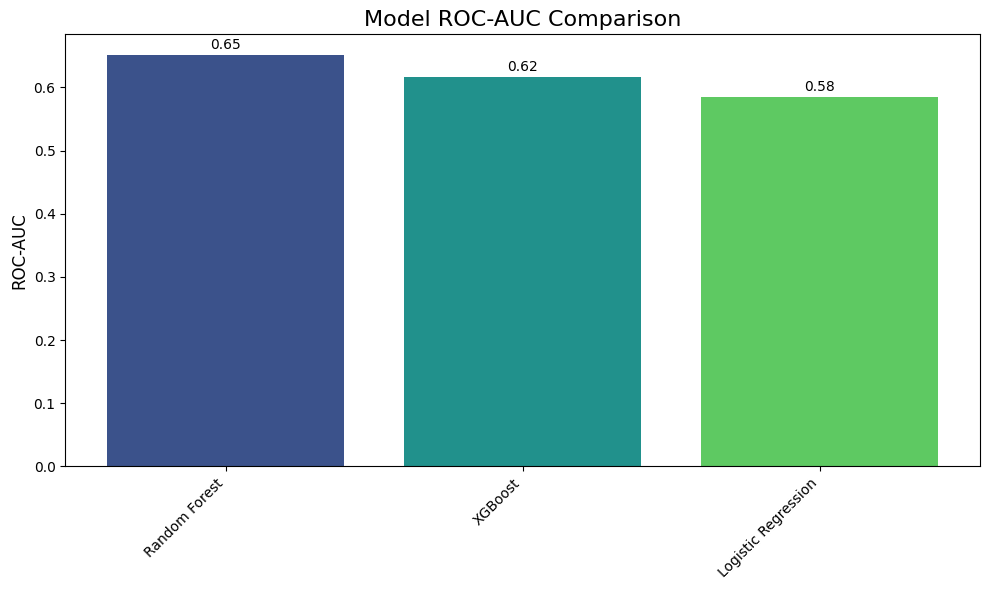

In [ ]:
# ROC-AUC 비교
sorted_results = dict(sorted(results.items(), key=lambda x: x[1]['roc_auc'], reverse=True))  # ROC-AUC 기준 정렬

plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", len(sorted_results))  # 색상 팔레트
plt.bar(sorted_results.keys(), [res['roc_auc'] for res in sorted_results.values()], color=colors)

# 그래프 제목 및 축 설정
plt.title("Model ROC-AUC Comparison", fontsize=16)
plt.ylabel("ROC-AUC", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)

# 각 바 위에 ROC-AUC 값 표시
for i, v in enumerate([res['roc_auc'] for res in sorted_results.values()]):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()
